# Augmentation

Augmentation for MRI has its limitaions. The model needs to recognize a specific pattern or shape that is common for each class and it can be disturbed by the augmentation. I will fit the models using augmented images from ImageDataGenerator and Albumentations. Ideas for augmentation types from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5977656/

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow import cast, image, numpy_function
from tensorflow.keras.applications import EfficientNetV2S, resnet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import resnet50
from tensorflow.image import grayscale_to_rgb
from tensorflow import convert_to_tensor
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow import expand_dims

import albumentations as A
import cv2
from os import listdir
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import functions

import numpy as np
np.random.seed(18)

In [2]:
# Set image size
image_size = 240

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Path to Alzheimer's data
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Path to Brain Tumor data
bt_path_train = '../data/brain_tumor/train'
bt_path_test = '../data/brain_tumor/test'

In [69]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        zoom_range=0.1,        
        width_shift_range=0.05,
        height_shift_range=0.05, 
        horizontal_flip=True,
        validation_split=0.20) 

Found 5121 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


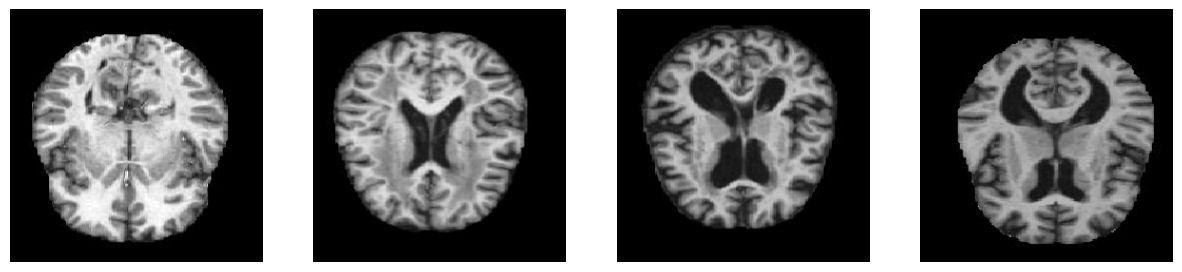

In [60]:
al_train_dg = datagen.flow_from_directory(
                  directory=al_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18 # to make the result reproducible
                  )

al_val_dg = datagen.flow_from_directory(
                  directory=al_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18,
                  shuffle=True,
                  subset='validation'
                  )


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
    # convert to unsigned integers for plotting
    image = next(al_train_dg)[0].astype('uint8')

    # changing size for plotting the image
    image = np.squeeze(image)

    # plot raw pixel data
    ax[i].imshow(image)
    ax[i].axis('off')

In [7]:
es = EarlyStopping(patience = 5)

model = Sequential()


model.add(layers.Input(shape=(image_size, image_size, 1)))
model.add(layers.Rescaling(1./255))

#First Convolution
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Second Convolution
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Flatten
model.add(Flatten())
# Fully Connected
model.add(Dense(32, activation = 'relu'))
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = model.fit(al_train_dg, validation_data = al_val_dg, steps_per_epoch=len(al_train_dg) / 32, epochs=50, callbacks = [es])

Epoch 1/50
160/160 [==============================] - 15s 88ms/step - loss: 1.4372 - accuracy: 0.4472 - val_loss: 1.2433 - val_accuracy: 0.5005
Epoch 2/50
160/160 [==============================] - 13s 83ms/step - loss: 1.1464 - accuracy: 0.4037 - val_loss: 1.0429 - val_accuracy: 0.5005
Epoch 3/50
160/160 [==============================] - 13s 83ms/step - loss: 1.0644 - accuracy: 0.5280 - val_loss: 1.0590 - val_accuracy: 0.5005
Epoch 4/50
160/160 [==============================] - 14s 87ms/step - loss: 1.1192 - accuracy: 0.4969 - val_loss: 1.1659 - val_accuracy: 0.3500
Epoch 5/50
160/160 [==============================] - 13s 80ms/step - loss: 1.0524 - accuracy: 0.4596 - val_loss: 1.0411 - val_accuracy: 0.5005
Epoch 6/50
160/160 [==============================] - 13s 84ms/step - loss: 0.9918 - accuracy: 0.5280 - val_loss: 1.0414 - val_accuracy: 0.5005
Epoch 7/50
160/160 [==============================] - 13s 81ms/step - loss: 1.0362 - accuracy: 0.4783 - val_loss: 1.0372 - val_accuracy:

The model fails to learn anything from augmented data.

# Brain Tumor

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


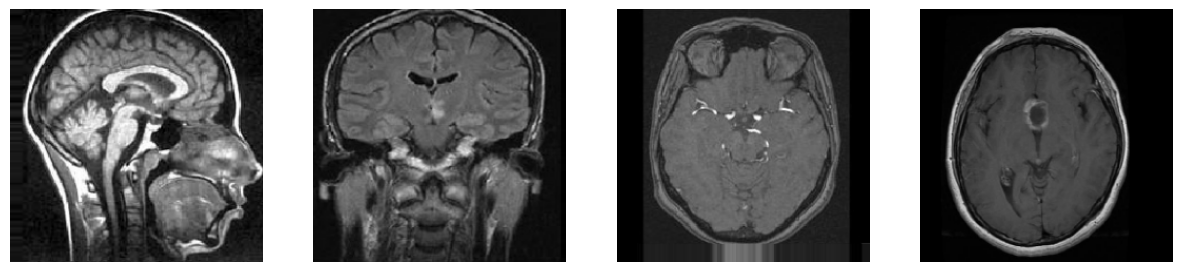

In [70]:
bt_train_dg = datagen.flow_from_directory(
                  directory=bt_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18,
                  shuffle=True,
                  subset='training'
                  )

bt_val_dg = datagen.flow_from_directory(
                  directory=bt_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18,
                  shuffle=True,
                  subset='validation'
                  )

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
    # convert to unsigned integers for plotting
    image = next(bt_train_dg)[0].astype('uint8')

    # changing size for plotting the image
    image = np.squeeze(image)

    # plot raw pixel data
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')

In [71]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax",
    include_preprocessing=True,
)

# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

    
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(effnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    

h = model.fit(bt_train_dg, validation_data = bt_val_dg, steps_per_epoch=len(bt_train_dg) / 32, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
71/71 [==============================] - 215s 3s/step - loss: 1.3652 - accuracy: 0.3889 - val_loss: 1.3084 - val_accuracy: 0.3141 - lr: 0.0010
Epoch 2/30
71/71 [==============================] - 189s 3s/step - loss: 1.3256 - accuracy: 0.3611 - val_loss: 1.2363 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 3/30
71/71 [==============================] - 146s 2s/step - loss: 1.3173 - accuracy: 0.3056 - val_loss: 1.1463 - val_accuracy: 0.4363 - lr: 0.0010
Epoch 4/30
71/71 [==============================] - 76s 1s/step - loss: 1.2340 - accuracy: 0.4444 - val_loss: 1.1493 - val_accuracy: 0.4677 - lr: 0.0010
Epoch 5/30
71/71 [==============================] - 124s 2s/step - loss: 1.2525 - accuracy: 0.4722 - val_loss: 1.2015 - val_accuracy: 0.4433 - lr: 0.0010
Epoch 6/30
71/71 [==============================] - 77s 1s/step - loss: 1.2068 - accuracy: 0.4306 - val_loss: 1.1124 - val_accuracy: 0.5131 - lr: 0.0010
Epoch 7/30
71/71 [==============================] - 121s 2s/step - loss: 1.275

For Brain Tumors, augmentation works even worse than for Alzheimer's. I will try Albumentations and add the augmented images to the training set to increase the number of images to train on. 

## Albumentations 

In [41]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.Rotate(limit=10, p=0.5),    
    #A.RandomScale(scale_limit=0.1, p=0.5)
])

in functions

In [27]:
def ald_augmentation(X_train, y_train):
    # Make a copy of the training set and augment it
    X_aug = []
    for image in X_train:
        image = transform(image=image)['image']
        image = cv2.resize(image, (image_size, image_size))
        X_aug.append(image)
    # Add augmented data to training set
    X_train = X_train + X_aug
    y_train = y_train + y_train
    # Prepare data for Tensorflow model
    X_train = np.array(X_train, dtype='float32')
    y_train = to_categorical(y_train, num_classes=4, dtype='float32')
    return X_train, y_train

In [28]:
def alb_prepare_data(path):
    X = []
    y = []

    for num_label, label in enumerate(listdir(path)):
            # Change each image and append to X and y
            for image in listdir(f'{path}/{label}'):
                if '.jpg' in image:
                    img = load_img(f'{path}/{label}/{image}', target_size=(image_size, image_size), color_mode='grayscale')
                    img = expand_dims(img, -1)
                    # Make image RGB for pre-trained models
                    img = grayscale_to_rgb(img)
                    img_arr = img_to_array(img) 

                    X.append(img_arr)
                    y.append(num_label)
                    
    if 'train' in path:     
            X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
                   
            X_val = np.array(X_val, dtype='float32')
            y_val = to_categorical(y_val, num_classes=4, dtype='float32')
            # Apply augmentation on trainig set 
            X_train, y_train = functions.ald_augmentation(X_train, y_train)
            return X_train, X_val, y_train, y_val
    else:
            
            X_test = np.array(X, dtype='float32')
            y_test = to_categorical(y, num_classes=4, dtype='float32')
            return X_test, y_test

### Alzheimer's

In [42]:
X_train, X_val, y_train, y_val = alb_prepare_data(al_path_train)
# Check the shape of the data
X_train.shape, y_train.shape

((7680, 240, 240, 3), (7680, 4))

In [43]:
X_test, y_test = alb_prepare_data(al_path_test)

In [44]:
# This model gave better scores on non augmented data
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [45]:
# Freeze layers
for layer in rn_model.layers:
    layer.trainable = False

In [46]:
model = Sequential()

model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), steps_per_epoch=len(X_train) / 32, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
240/240 [==============================] - 658s 3s/step - loss: 5.3511 - accuracy: 0.5607 - val_loss: 13.3514 - val_accuracy: 0.5995 - lr: 0.0010
Epoch 2/30
240/240 [==============================] - 666s 3s/step - loss: 2.8846 - accuracy: 0.6940 - val_loss: 1.2842 - val_accuracy: 0.8228 - lr: 0.0010
Epoch 3/30
240/240 [==============================] - 905s 4s/step - loss: 1.6280 - accuracy: 0.7707 - val_loss: 2.7237 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 4/30
240/240 [==============================] - 1015s 4s/step - loss: 1.6515 - accuracy: 0.7837 - val_loss: 1.8538 - val_accuracy: 0.7986 - lr: 0.0010
Epoch 5/30
240/240 [==============================] - 1034s 4s/step - loss: 2.1410 - accuracy: 0.7715 - val_loss: 1.4721 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 6/30
240/240 [==============================] - 1019s 4s/step - loss: 1.3690 - accuracy: 0.8266 - val_loss: 2.0237 - val_accuracy: 0.8158 - lr: 0.0010
Epoch 7/30
240/240 [==============================] - 1034s 

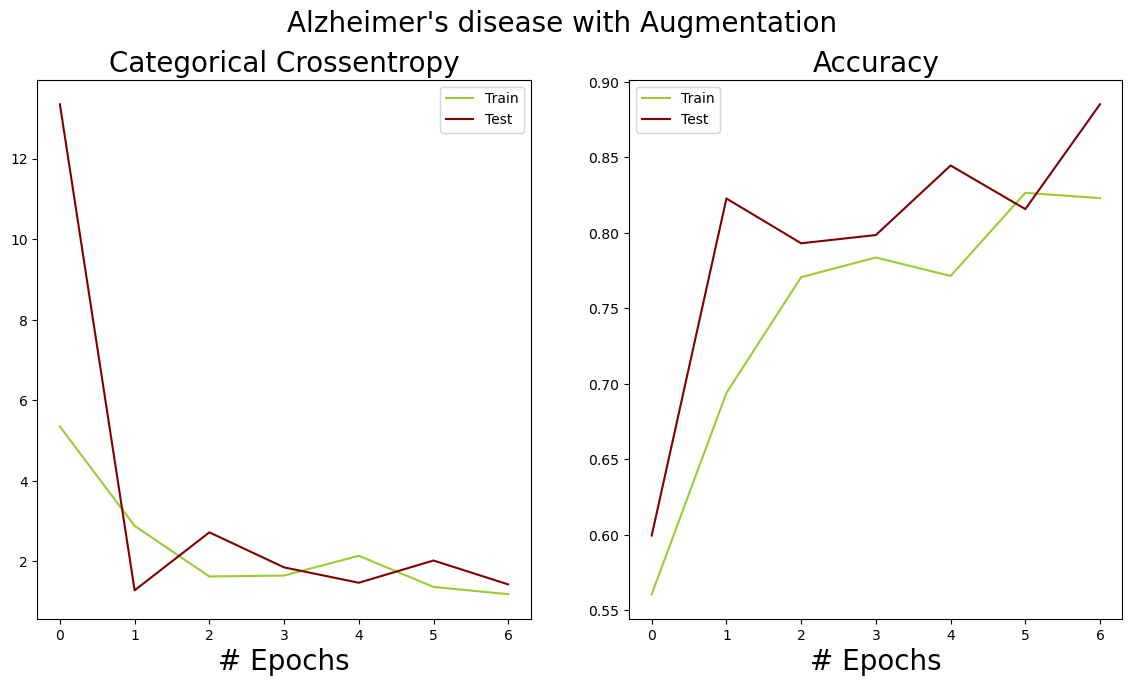

In [47]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with Augmentation')

Accuracy_score: 0.8228 



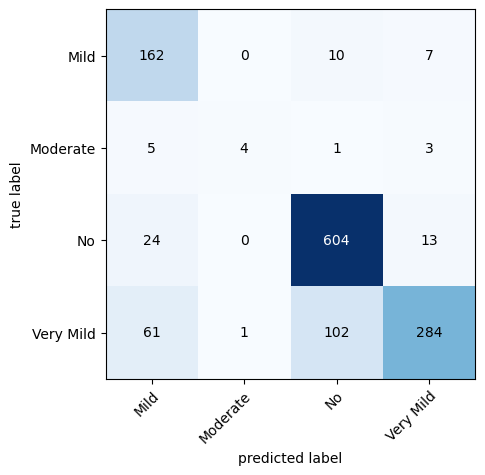

In [48]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.674 



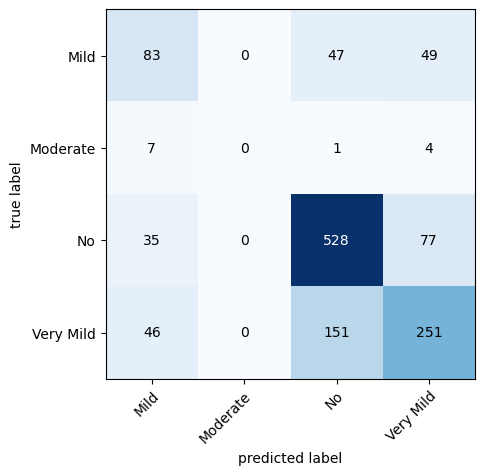

In [49]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

In [62]:
transform = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.RandomBrightnessContrast(p=0.15),
    A.GaussNoise(p=0.4),
    A.Rotate(limit=10, p=0.25),    
    #A.RandomScale(scale_limit=0.1, p=0.15)
])

In [63]:
X_train, X_val, y_train, y_val = alb_prepare_data(al_path_train)
# Check the shape of the data
X_train.shape, y_train.shape

((7680, 240, 240, 3), (7680, 4))

In [64]:
X_test, y_test = alb_prepare_data(al_path_test)

In [65]:
model = Sequential()

model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), steps_per_epoch=len(X_train) / 32, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
240/240 [==============================] - 1464s 6s/step - loss: 5.9667 - accuracy: 0.5720 - val_loss: 2.0212 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 2/30
240/240 [==============================] - 1449s 6s/step - loss: 2.4930 - accuracy: 0.7008 - val_loss: 1.2583 - val_accuracy: 0.8165 - lr: 0.0010
Epoch 3/30
240/240 [==============================] - ETA: 0s - loss: 1.5145 - accuracy: 0.7870

KeyboardInterrupt: 

In [ ]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with Augmentation')

In [ ]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

In [ ]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Augmentation did not improve the accuracy of the model. Without Augmentation accuracy was 0.67

### Brain Tumor

Did not work:

removed Gauss Noise, Hor_flip, all hight, anly augmented, 

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.RandomBrightnessContrast(p=0.25),
    A.GaussNoise(p=0.5),
    #A.Rotate(limit=10, p=0.5),    
    #A.RandomScale(scale_limit=0.1, p=0.5)
])
0.61

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.25),
    #A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.Rotate(limit=10, p=0.5),    
    A.RandomScale(scale_limit=0.1, p=0.25)
])
0.76

# Best so far

In [50]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.Rotate(limit=10, p=0.25),    
    #A.RandomScale(scale_limit=0.1, p=0.5)
])

In [51]:
X_train, X_val, y_train, y_val = alb_prepare_data(bt_path_train)
X_train.shape, y_train.shape

((4304, 240, 240, 3), (4304, 4))

In [52]:
X_test, y_test = alb_prepare_data(bt_path_test)

In [53]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax",
    include_preprocessing=True,
)
# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

In [54]:
model = Sequential()

model.add(effnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_efv2s = model.fit(X_train, y_train, validation_data = (X_val, y_val), steps_per_epoch=len(X_train) / 32, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
134/134 [==============================] - 823s 6s/step - loss: 0.8122 - accuracy: 0.6345 - val_loss: 0.3889 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 2/30
134/134 [==============================] - 754s 6s/step - loss: 0.6722 - accuracy: 0.6961 - val_loss: 0.2920 - val_accuracy: 0.9011 - lr: 0.0010
Epoch 3/30
134/134 [==============================] - 749s 6s/step - loss: 0.6222 - accuracy: 0.7142 - val_loss: 0.2801 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 4/30
134/134 [==============================] - 752s 6s/step - loss: 0.5928 - accuracy: 0.7309 - val_loss: 0.2669 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 5/30
134/134 [==============================] - 757s 6s/step - loss: 0.5708 - accuracy: 0.7386 - val_loss: 0.2398 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 6/30
134/134 [==============================] - 748s 6s/step - loss: 0.5442 - accuracy: 0.7479 - val_loss: 0.3000 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 7/30
134/134 [==============================] - 752s 6s/st

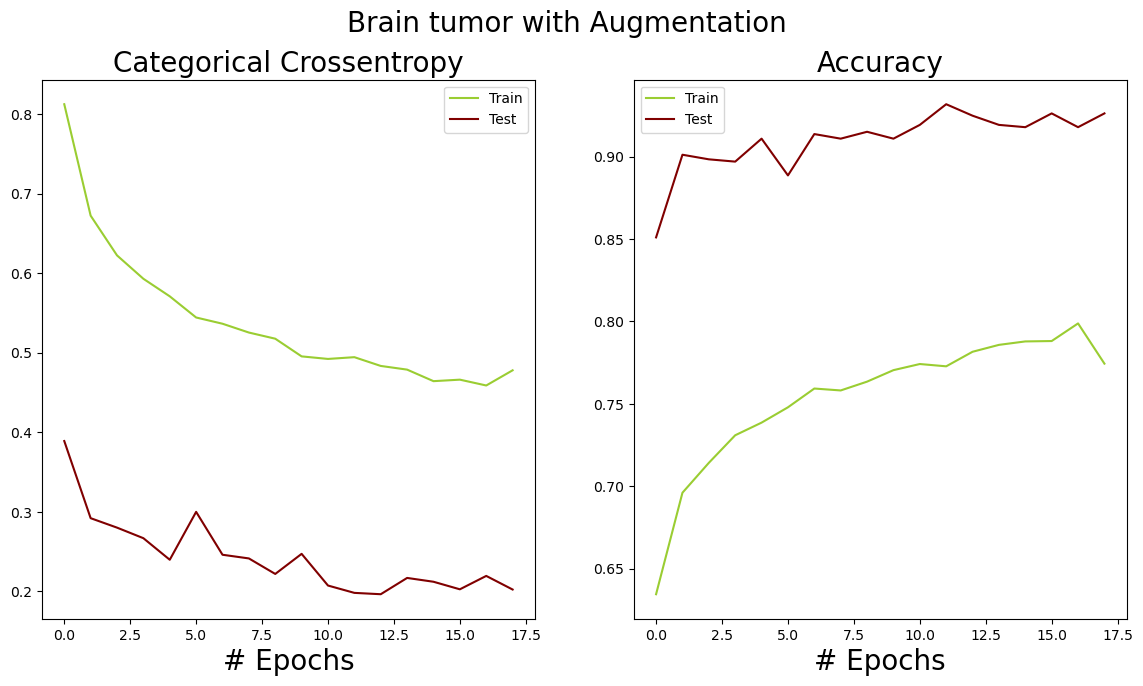

In [55]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_efv2s, 'Brain tumor with Augmentation')

Accuracy_score: 0.9248 



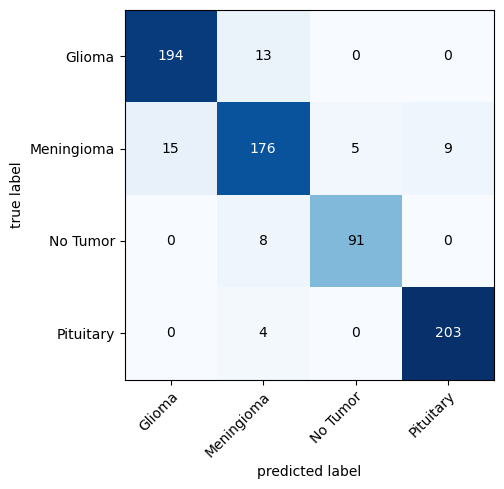

In [56]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])

Accuracy_score: 0.7817 



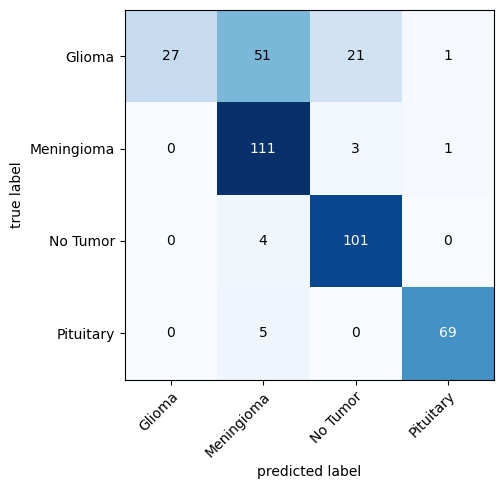

In [57]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])

In [117]:
model = Sequential()

model.add(effnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_efv2s = model.fit(X_train, y_train, validation_data = (X_val, y_val), steps_per_epoch=len(X_train) / 32, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
134/134 [==============================] - 275s 2s/step - loss: 0.7829 - accuracy: 0.6540 - val_loss: 0.3765 - val_accuracy: 0.8524 - lr: 0.0010
Epoch 2/30
134/134 [==============================] - 261s 2s/step - loss: 0.6232 - accuracy: 0.7212 - val_loss: 0.3245 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 3/30
134/134 [==============================] - 257s 2s/step - loss: 0.5600 - accuracy: 0.7558 - val_loss: 0.3041 - val_accuracy: 0.8816 - lr: 0.0010
Epoch 4/30
134/134 [==============================] - 263s 2s/step - loss: 0.5319 - accuracy: 0.7609 - val_loss: 0.3288 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 5/30
134/134 [==============================] - 264s 2s/step - loss: 0.4974 - accuracy: 0.7688 - val_loss: 0.2646 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 6/30
134/134 [==============================] - 258s 2s/step - loss: 0.4762 - accuracy: 0.7874 - val_loss: 0.3063 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 7/30
134/134 [==============================] - 258s 2s/st

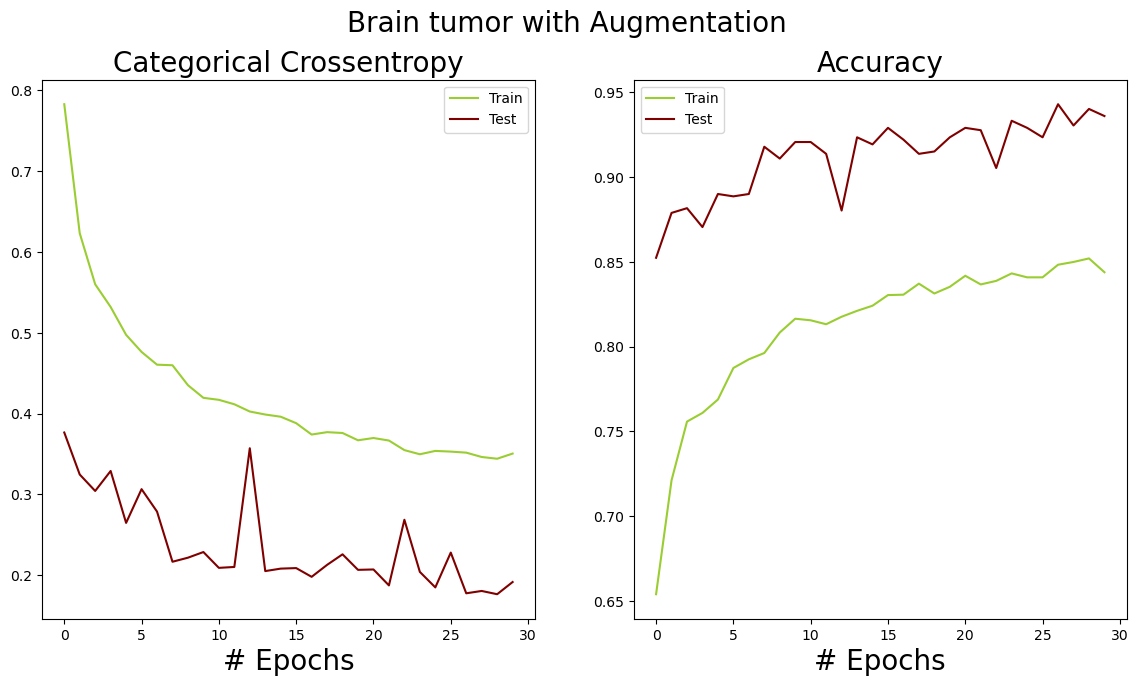

In [118]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_efv2s, 'Brain tumor with Augmentation')

Accuracy_score: 0.9359 



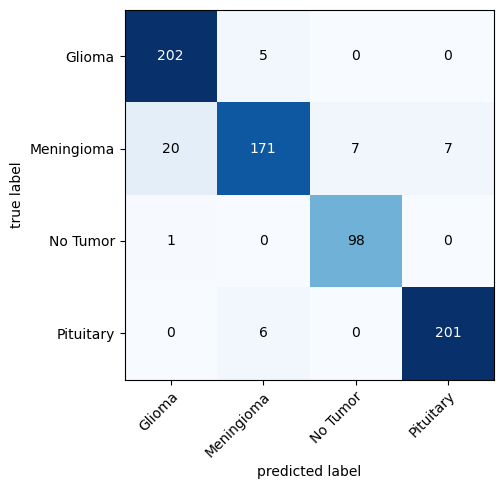

In [119]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])

Accuracy_score: 0.7538 



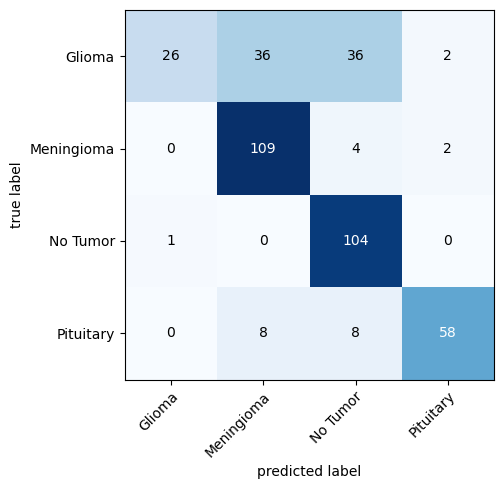

In [120]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])

---

I have tried ImageDataGenerator and Albumentations neither of them imroved the scores of the models.